# Isolation Forest Anomaly Detection for CMS Open Payments

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Context:** Continuation of notebook 02 - Data Exploration & Analysis  
**Objective:** Train an Isolation Forest model to detect anomalous payment patterns using ensemble-based outlier detection

---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Load Data from Stored Variables](#loading)
3. [Data Preparation & Feature Engineering](#preparation)
4. [Isolation Forest Configuration](#configuration)
5. [Model Training](#training)
6. [Performance Evaluation](#evaluation)
7. [Anomaly Score Calculation & Validation](#scoring)
8. [Visualizations & Metrics](#visualizations)
9. [Summary & Outputs](#summary)

---

## 1. Setup & Data Loading

Load dependencies and restore configuration from notebook 02 (EDA).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import awswrangler as wr
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r s3_parquet_path
%store -r s3_athena_staging
%store -r df

if 'df' not in dir() or df is None:
    raise NameError("Missing required variable 'df'. Run notebook 02 first.")
    
print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")
print(f"Dataset shape: {df.shape}")

no stored variable or alias s3_parquet_path
Region: us-east-1 | Bucket: cmsopenpaymentsystemslight | Database: cms_open_payments_light
Dataset shape: (997362, 31)


## 2. Load Data from Stored Variables

Use the cleaned and processed dataset from notebook 02.

In [3]:
df_payments = df.copy()
display(df_payments.head(3))
print(f"Dataset loaded: {df_payments.shape}")

,total_amount_of_payment_usdollars,number_of_payments_included_in_total_amount,date_of_payment,covered_recipient_type,nature_of_payment_or_transfer_of_value,form_of_payment_or_transfer_of_value,recipient_state,covered_recipient_profile_id,covered_recipient_npi,applicable_manufacturer_or_applicable_gpo_making_payment_name,...,hist_pay_std,hist_pay_max,amt_to_avg_ratio,amt_to_max_ratio,is_new_recipient,is_high_risk_nature,total_amount_of_payment_usdollars_scaled,hist_pay_avg_scaled,hist_pay_std_scaled,amt_to_avg_ratio_scaled
0,21.68,1.0,2024-05-01,Covered Recipient Physician,Food and Beverage,In-kind items and services,NJ,189597.0,1.174589493E9,Bayer Healthcare Pharmaceuticals Inc.,...,0.000000,21.68,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16
1,20.02,19.0,2024-05-01,Covered Recipient Non-Physician Practitioner,1,07/09/2024,MO,1.1436307E7,1.598470684E9,100000000226,...,2.588011,18.11,1.22973,1.105467,0,0,-0.006531,-0.007226,-0.006588,4.674152e-01
2,20.02,64.0,2024-05-01,Covered Recipient Physician,1,02/28/2024,OH,268013.0,1.912181389E9,100000186746,...,0.000000,20.02,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16


Dataset loaded: (997362, 31)


## 3. Data Preparation & Feature Engineering

Prepare features for Isolation Forest training with appropriate preprocessing.

In [4]:
# Select numeric features for anomaly detection
numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

# Exclude identifier and non-relevant columns
cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_code', '_province', '_postal'])]

# Create feature matrix
X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

# Remove columns with excessive missing values (>50%)
missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

# Handle outliers using IQR method
for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

# Fill remaining missing values with median
X = X.fillna(X.median())

print(f"Features prepared: {X.shape}")
print(f"Selected features: {list(X.columns)}")

Features prepared: (997362, 20)
Selected features: ['total_amount_of_payment_usdollars', 'number_of_payments_included_in_total_amount', 'payment_year', 'payment_month', 'payment_quarter', 'payment_dayofweek', 'is_weekend', 'hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 'hist_pay_std', 'hist_pay_max', 'amt_to_avg_ratio', 'amt_to_max_ratio', 'is_new_recipient', 'is_high_risk_nature', 'total_amount_of_payment_usdollars_scaled', 'hist_pay_avg_scaled', 'hist_pay_std_scaled', 'amt_to_avg_ratio_scaled']


In [5]:
# Scale features using RobustScaler (better for outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled data: {X_scaled.shape}")
print(f"Range: [{X_scaled.min().min():.4f}, {X_scaled.max().max():.4f}]")

# Split into train and test sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Scaled data: (997362, 20)
Range: [-3.5403, 4.0000]
Train: 797,889 | Test: 199,473


## 4. Isolation Forest Configuration

Configure the Isolation Forest model with optimal hyperparameters.

In [6]:
# Isolation Forest hyperparameters
n_estimators = 200  # Number of trees in the forest
contamination = 0.05  # Expected proportion of anomalies (5%)
max_samples = 'auto'  # Number of samples to draw from X to train each tree
random_state = 42

print(f"Configuration:")
print(f"  Trees: {n_estimators}")
print(f"  Contamination: {contamination}")
print(f"  Max Samples: {max_samples}")
print(f"  Random State: {random_state}")

Configuration:
  Trees: 200
  Contamination: 0.05
  Max Samples: auto
  Random State: 42


## 5. Model Training

Train the Isolation Forest model on the prepared dataset.

In [7]:
# Initialize Isolation Forest
isolation_forest = IsolationForest(
    n_estimators=n_estimators,
    contamination=contamination,
    max_samples=max_samples,
    random_state=random_state,
    n_jobs=-1,
    verbose=0
)

print("Training Isolation Forest...")
start_time = time.time()

# Fit the model on training data
isolation_forest.fit(X_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f}s")

Training Isolation Forest...
Training completed in 10.81s


## 6. Performance Evaluation

Evaluate model performance and generate predictions on train and test sets.

In [8]:
# Generate predictions and anomaly scores
train_predictions = isolation_forest.predict(X_train)
train_scores = isolation_forest.decision_function(X_train)

test_predictions = isolation_forest.predict(X_test)
test_scores = isolation_forest.decision_function(X_test)

# Convert predictions: -1 (anomaly) to 1, 1 (normal) to 0
train_anomalies = (train_predictions == -1).astype(int)
test_anomalies = (test_predictions == -1).astype(int)

train_anomaly_count = train_anomalies.sum()
test_anomaly_count = test_anomalies.sum()

print(f"Train Anomalies: {train_anomaly_count:,}/{len(X_train):,} ({train_anomaly_count/len(X_train)*100:.2f}%)")
print(f"Test Anomalies: {test_anomaly_count:,}/{len(X_test):,} ({test_anomaly_count/len(X_test)*100:.2f}%)")
print(f"\nScore Statistics:")
print(f"  Train - Mean: {train_scores.mean():.4f} | Median: {np.median(train_scores):.4f} | Std: {train_scores.std():.4f}")
print(f"  Test - Mean: {test_scores.mean():.4f} | Median: {np.median(test_scores):.4f} | Std: {test_scores.std():.4f}")

Train Anomalies: 39,892/797,889 (5.00%)
Test Anomalies: 9,838/199,473 (4.93%)

Score Statistics:
  Train - Mean: 0.1124 | Median: 0.1175 | Std: 0.0626
  Test - Mean: 0.1127 | Median: 0.1180 | Std: 0.0625


## 7. Anomaly Score Calculation & Validation

Calculate anomaly scores and validate detected anomalies with payment details.

In [9]:
# Combine all data for comprehensive analysis
all_data = np.vstack([X_train, X_test])
all_predictions = isolation_forest.predict(all_data)
all_scores = isolation_forest.decision_function(all_data)

# Calculate threshold (decision boundary)
threshold = isolation_forest.offset_

anomaly_labels = (all_predictions == -1).astype(int)
anomaly_count = anomaly_labels.sum()
anomaly_percentage = (anomaly_count / len(anomaly_labels)) * 100

print(f"Decision Threshold: {threshold:.6f}")
print(f"Total Anomalies: {anomaly_count:,}/{len(anomaly_labels):,} ({anomaly_percentage:.2f}%)")
print(f"Score Range: [{all_scores.min():.6f}, {all_scores.max():.6f}]")

Decision Threshold: -0.592850
Total Anomalies: 49,730/997,362 (4.99%)
Score Range: [-0.086510, 0.220314]


### Validation: Inspect Detected Anomalies

Examine the payment details of detected anomalies to validate model performance.

In [10]:
# Create results dataframe with anomaly scores
anomaly_results = df_payments.copy()
anomaly_results['anomaly_score'] = all_scores
anomaly_results['is_anomaly'] = anomaly_labels
anomaly_results['anomaly_score_percentile'] = pd.Series(all_scores).rank(pct=True) * 100

# Filter anomalies and normal payments
anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('anomaly_score', ascending=True)  # Lower scores = more anomalous
normal_df = anomaly_results[anomaly_results['is_anomaly'] == 0]

# Display key columns for top anomalies
display_cols = [
    'anomaly_score', 
    'anomaly_score_percentile',
    'total_amount_of_payment_usdollars',
    'covered_recipient_type',
    'nature_of_payment_or_transfer_of_value'
]

# Add optional columns if they exist
optional_cols = ['amt_to_avg_ratio', 'hist_pay_avg', 'is_new_recipient', 
                'is_weekend', 'is_high_risk_nature']
for col in optional_cols:
    if col in anomalies_df.columns:
        display_cols.append(col)

available_cols = [col for col in display_cols if col in anomalies_df.columns]
print(f"Top 10 Anomalous Payments (n={len(anomalies_df):,}):")
display(anomalies_df[available_cols].head(10))

# Statistical comparison
comparison_features = ['total_amount_of_payment_usdollars']
optional_comparison = ['amt_to_avg_ratio', 'hist_pay_avg']
for col in optional_comparison:
    if col in anomaly_results.columns:
        comparison_features.append(col)

if comparison_features:
    comparison_stats = pd.DataFrame({
        'Normal_Mean': normal_df[comparison_features].mean(),
        'Normal_Median': normal_df[comparison_features].median(),
        'Anomaly_Mean': anomalies_df[comparison_features].mean(),
        'Anomaly_Median': anomalies_df[comparison_features].median(),
        'Difference_%': ((anomalies_df[comparison_features].mean() - normal_df[comparison_features].mean()) / 
                        normal_df[comparison_features].mean() * 100)
    })
    print("\nStatistical Comparison:")
    display(comparison_stats)

Top 10 Anomalous Payments (n=49,730):


,anomaly_score,anomaly_score_percentile,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
750673,-0.086510,0.000100,15.02,Covered Recipient Non-Physician Practitioner,Food and Beverage,0.800213,18.7700,0,0,0
557613,-0.081045,0.000201,20.02,Covered Recipient Non-Physician Practitioner,1,1.393180,14.3700,0,0,0
212862,-0.080030,0.000301,20.02,Covered Recipient Non-Physician Practitioner,Cash or cash equivalent,1.000000,20.0200,1,0,0
317316,-0.079029,0.000401,20.02,Covered Recipient Physician,1,1.279233,15.6500,0,0,0
680544,-0.076767,0.000501,20.02,Covered Recipient Non-Physician Practitioner,1,0.795707,25.1600,0,0,0
74760,-0.075821,0.000602,20.02,Covered Recipient Physician,1,1.098642,18.2225,0,0,0
722752,-0.074132,0.000702,20.02,Covered Recipient Non-Physician Practitioner,1,1.000000,20.0200,1,0,0
636096,-0.073156,0.000902,136.54,Covered Recipient Physician,Food and Beverage,6.820180,20.0200,1,0,0
798964,-0.073156,0.000902,20.02,Covered Recipient Physician,1,1.013414,19.7550,0,0,0
796021,-0.073156,0.000902,20.02,Covered Recipient Physician,1,1.000000,20.0200,0,0,0



Statistical Comparison:


,Normal_Mean,Normal_Median,Anomaly_Mean,Anomaly_Median,Difference_%
total_amount_of_payment_usdollars,64.569955,20.02,66.169753,20.02,2.477619
amt_to_avg_ratio,1.657144,1.00,1.658396,1.00,0.075561
hist_pay_avg,58.627874,20.02,60.109918,20.02,2.527883


In [11]:
# Anomaly distribution by key categories
categorical_cols = ['covered_recipient_type', 'nature_of_payment_or_transfer_of_value']
optional_categorical = ['is_high_risk_nature', 'is_weekend', 'is_new_recipient']

for col in optional_categorical:
    if col in anomalies_df.columns:
        categorical_cols.append(col)

categorical_cols = [col for col in categorical_cols if col in anomalies_df.columns]

if categorical_cols:
    print("\nAnomaly Distribution by Category:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(anomalies_df[col].value_counts().head(5))

# Anomaly score statistics
score_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Min', 'Max'],
    'Normal': [
        normal_df['anomaly_score'].mean(),
        normal_df['anomaly_score'].median(),
        normal_df['anomaly_score'].min(),
        normal_df['anomaly_score'].max()
    ],
    'Anomaly': [
        anomalies_df['anomaly_score'].mean(),
        anomalies_df['anomaly_score'].median(),
        anomalies_df['anomaly_score'].min(),
        anomalies_df['anomaly_score'].max()
    ]
})

print("\nAnomaly Score Statistics:")
display(score_stats)


Anomaly Distribution by Category:

covered_recipient_type:
covered_recipient_type
Covered Recipient Physician                     31961
Covered Recipient Non-Physician Practitioner    17769
Name: count, dtype: Int64

nature_of_payment_or_transfer_of_value:
nature_of_payment_or_transfer_of_value
Food and Beverage             25226
1                             17808
In-kind items and services     2331
Cash or cash equivalent        1021
Travel and Lodging              795
Name: count, dtype: Int64

is_high_risk_nature:
is_high_risk_nature
0    48885
1      845
Name: count, dtype: int64

is_weekend:
is_weekend
0    47990
1     1740
Name: count, dtype: int64

is_new_recipient:
is_new_recipient
0    39619
1    10111
Name: count, dtype: int64

Anomaly Score Statistics:


,Metric,Normal,Anomaly
0,Mean,0.119085,-1.410337e-02
1,Median,0.122705,-1.136466e-02
2,Min,0.000000,-8.650985e-02
3,Max,0.220314,-2.066379e-07


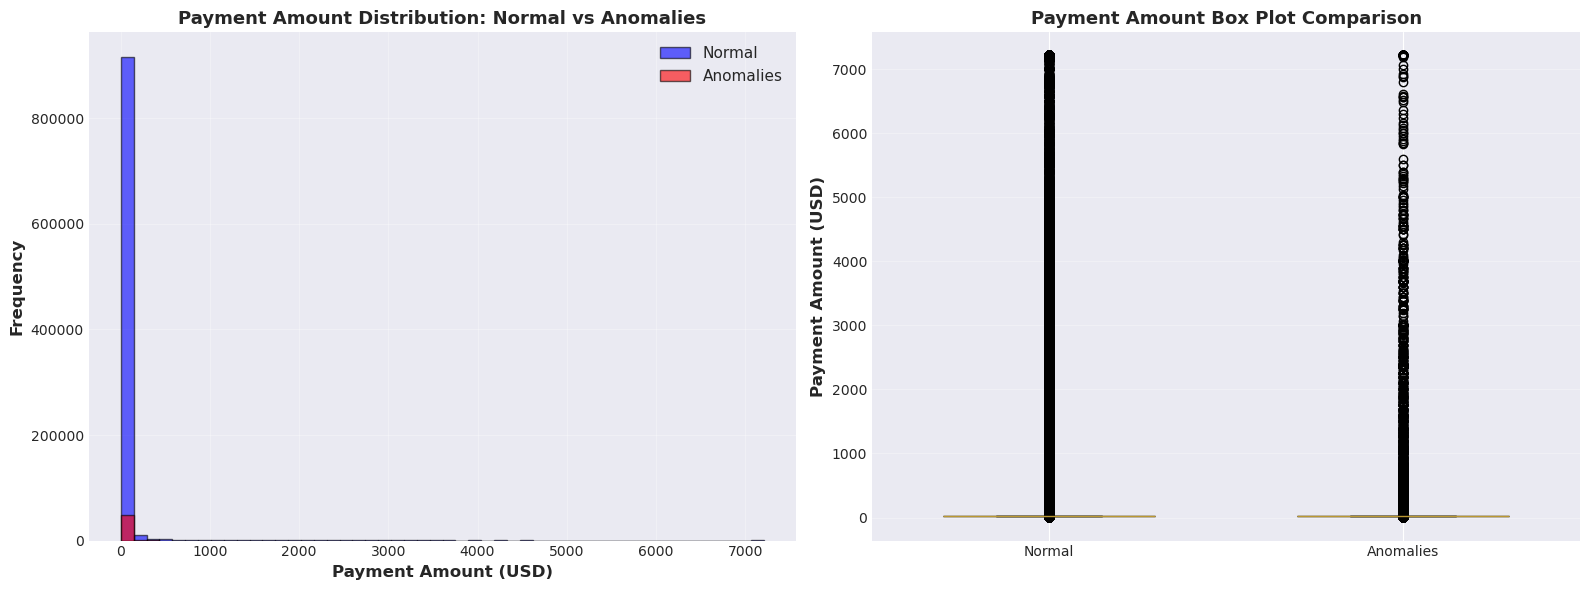

In [12]:
# Visualize payment amount distribution: Normal vs Anomalies
if 'total_amount_of_payment_usdollars' in anomaly_results.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    normal_amounts = normal_df['total_amount_of_payment_usdollars']
    anomaly_amounts = anomalies_df['total_amount_of_payment_usdollars']
    
    # Histogram comparison
    ax1 = axes[0]
    ax1.hist(normal_amounts, bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax1.hist(anomaly_amounts, bins=50, alpha=0.6, label='Anomalies', color='red', edgecolor='black')
    ax1.set_xlabel('Payment Amount (USD)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Payment Amount Distribution: Normal vs Anomalies', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2 = axes[1]
    data_to_plot = [normal_amounts, anomaly_amounts]
    bp = ax2.boxplot(data_to_plot, labels=['Normal', 'Anomalies'], 
                     patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax2.set_ylabel('Payment Amount (USD)', fontsize=12, fontweight='bold')
    ax2.set_title('Payment Amount Box Plot Comparison', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 8. Visualizations & Metrics

Visualize anomaly scores, distributions, and model performance metrics.

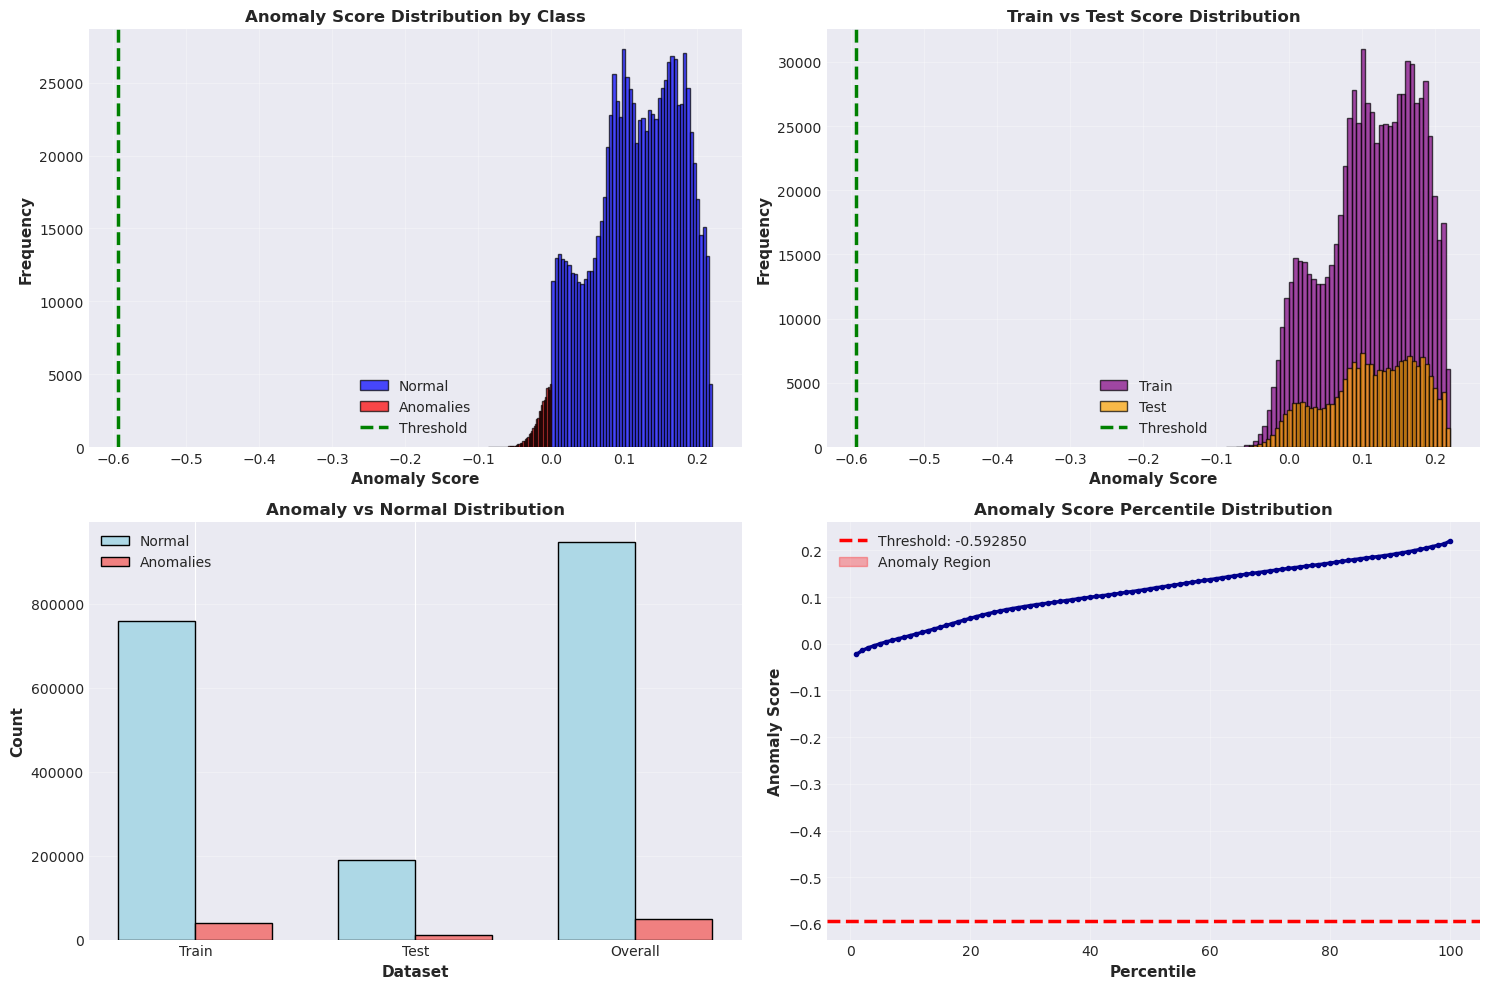

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Anomaly score distribution by class
ax1 = axes[0, 0]
ax1.hist(normal_df['anomaly_score'], bins=50, alpha=0.7, label='Normal', color='blue', edgecolor='black')
ax1.hist(anomalies_df['anomaly_score'], bins=50, alpha=0.7, label='Anomalies', color='red', edgecolor='black')
ax1.axvline(threshold, color='green', linestyle='--', linewidth=2.5, label=f'Threshold')
ax1.set_xlabel('Anomaly Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Anomaly Score Distribution by Class', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Train vs Test score distribution
ax2 = axes[0, 1]
ax2.hist(train_scores, bins=50, alpha=0.7, label='Train', color='purple', edgecolor='black')
ax2.hist(test_scores, bins=50, alpha=0.7, label='Test', color='orange', edgecolor='black')
ax2.axvline(threshold, color='green', linestyle='--', linewidth=2.5, label='Threshold')
ax2.set_xlabel('Anomaly Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Train vs Test Score Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Anomaly count comparison
ax3 = axes[1, 0]
categories = ['Train', 'Test', 'Overall']
anomaly_counts = [train_anomaly_count, test_anomaly_count, anomaly_count]
normal_counts = [len(X_train) - train_anomaly_count, 
                len(X_test) - test_anomaly_count,
                len(anomaly_labels) - anomaly_count]

x = np.arange(len(categories))
width = 0.35

bars1 = ax3.bar(x - width/2, normal_counts, width, label='Normal', color='lightblue', edgecolor='black')
bars2 = ax3.bar(x + width/2, anomaly_counts, width, label='Anomalies', color='lightcoral', edgecolor='black')

ax3.set_xlabel('Dataset', fontsize=11, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('Anomaly vs Normal Distribution', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Percentile distribution
ax4 = axes[1, 1]
percentiles = np.arange(1, 101)
ax4.plot(percentiles, np.percentile(all_scores, percentiles), 
        linewidth=2.5, color='darkblue', marker='o', markersize=3)
ax4.axhline(y=threshold, color='red', linestyle='--', linewidth=2.5, 
           label=f'Threshold: {threshold:.6f}')
ax4.fill_between(percentiles, threshold, np.percentile(all_scores, percentiles), 
                where=(np.percentile(all_scores, percentiles) < threshold),
                alpha=0.3, color='red', label='Anomaly Region')
ax4.set_xlabel('Percentile', fontsize=11, fontweight='bold')
ax4.set_ylabel('Anomaly Score', fontsize=11, fontweight='bold')
ax4.set_title('Anomaly Score Percentile Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary & Outputs

Save model and anomaly detection results for downstream analysis.

In [14]:
# Save the trained model
model_path = 'cms_isolation_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(isolation_forest, f)
print(f"Model saved: {model_path}")

# Save the scaler
scaler_path = 'isolation_forest_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved: {scaler_path}")

# Save anomaly results
results_path = 'anomaly_results_isolation_forest.csv'
anomaly_results.to_csv(results_path, index=False)
print(f"Results saved: {results_path}")

# Create execution summary
results_summary = pd.DataFrame({
    'Metric': ['Total Records', 'Train Records', 'Test Records',
               'Anomalies Detected', 'Anomaly Percentage', 
               'Decision Threshold', 'Mean Score', 'Training Time (sec)',
               'N Estimators', 'Contamination'],
    'Value': [len(anomaly_labels), len(X_train), len(X_test),
              anomaly_count, f'{anomaly_percentage:.2f}%',
              f'{threshold:.6f}', f'{all_scores.mean():.6f}',
              f'{training_time:.2f}', n_estimators, contamination]
})

print("\nExecution Summary:")
display(results_summary)

# Feature importance (based on anomaly detection contribution)
print("\nFeatures Used in Model:")
for i, feat in enumerate(X.columns, 1):
    print(f"{i}. {feat}")

Model saved: cms_isolation_forest_model.pkl
Scaler saved: isolation_forest_scaler.pkl
Results saved: anomaly_results_isolation_forest.csv

Execution Summary:


,Metric,Value
0,Total Records,997362
1,Train Records,797889
2,Test Records,199473
3,Anomalies Detected,49730
4,Anomaly Percentage,4.99%
5,Decision Threshold,-0.592850
6,Mean Score,0.112444
7,Training Time (sec),10.81
8,N Estimators,200
9,Contamination,0.05



Features Used in Model:
1. total_amount_of_payment_usdollars
2. number_of_payments_included_in_total_amount
3. payment_year
4. payment_month
5. payment_quarter
6. payment_dayofweek
7. is_weekend
8. hist_pay_count
9. hist_pay_total
10. hist_pay_avg
11. hist_pay_std
12. hist_pay_max
13. amt_to_avg_ratio
14. amt_to_max_ratio
15. is_new_recipient
16. is_high_risk_nature
17. total_amount_of_payment_usdollars_scaled
18. hist_pay_avg_scaled
19. hist_pay_std_scaled
20. amt_to_avg_ratio_scaled


In [15]:
# Store results for next notebook
%store anomaly_results
%store threshold
%store isolation_forest

print("Variables stored for next notebook")

Stored 'anomaly_results' (DataFrame)
Stored 'threshold' (float64)
Stored 'isolation_forest' (IsolationForest)
Variables stored for next notebook
